Forecasting Dutch TTF Natural Gas Prices using historical futures data. 

Dutch TTF (Title Transfer Facility) is the leading european gas price hub. TTF is the key virtual trading point for natural gas in the Netherlands and serves as the European benchmark for gas prices.

I want to forecast the front-month price (nearest expiring contract). My goal is to model short term price dynamics. Using front-month futures contract as a folling time series as it gives high liquidity (closer to true market signal), fewer gaps and cleaner data, best proxy for market expectations at a given point. 

I took the TFAc1 ticker from Investing.com which represents a continuous front-month futures series for Dutch TTF natural gas. It automatically rolls from the current month’s contract to the next one as expiry approaches. So in July 2024, it's showing the August 2024 contract; in August, it rolls to September 2024, and so on. The downside of using this data is we won't get long-term curve. It is not possible to model Q1 2026 price today. I'd need a different dataset showing forward curves. 

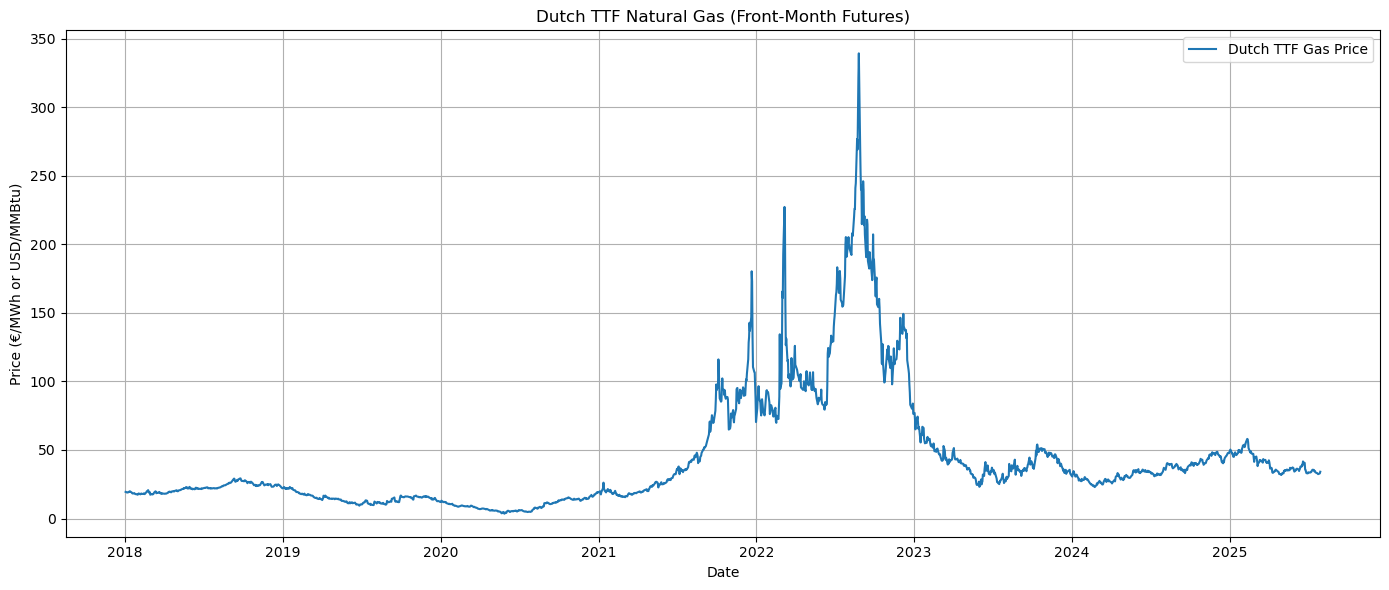

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../dutch_ttf_prices/ICE_Dutch_TTF_Natural_Gas_Futures_Historical_Data.csv")
#print(df.head())

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(df['Price'], label='Dutch TTF Gas Price')
plt.title('Dutch TTF Natural Gas (Front-Month Futures)')
plt.xlabel('Date')
plt.ylabel('Price (€/MWh or USD/MMBtu)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("../plots/time_series.jpg")
plt.show()
plt.close()

**Asset**: Dutch TTF Natural Gas (Front-Month Futures)
**Frequency**: Daily
**Period Covered**: January 2018 to July 2025

#### Interpretation:
 - The price was relatively stable from 2018 to mid-2021, typically ranging between €10 and €30/MWh.

 - Starting in late 2021, prices became extremely volatile, with several massive spikes during the 2021–2022 European energy crisis.

 - The peak occurs in mid-2022, with prices exceeding €300/MWh — more than 10× the pre-crisis norm.

 - After the peak, there's a sharp reversion, though prices remain more volatile than the pre-2021 period.

 #### Notes
  - This non-stationary behavior (trend shifts, volatility clustering, structural breaks) confirms the need for decomposition and stationarity testing before modeling.

   - Prices reflect geopolitical shocks, storage concerns, and seasonal heating/cooling demand. Seasonality is likely present and should be explored.

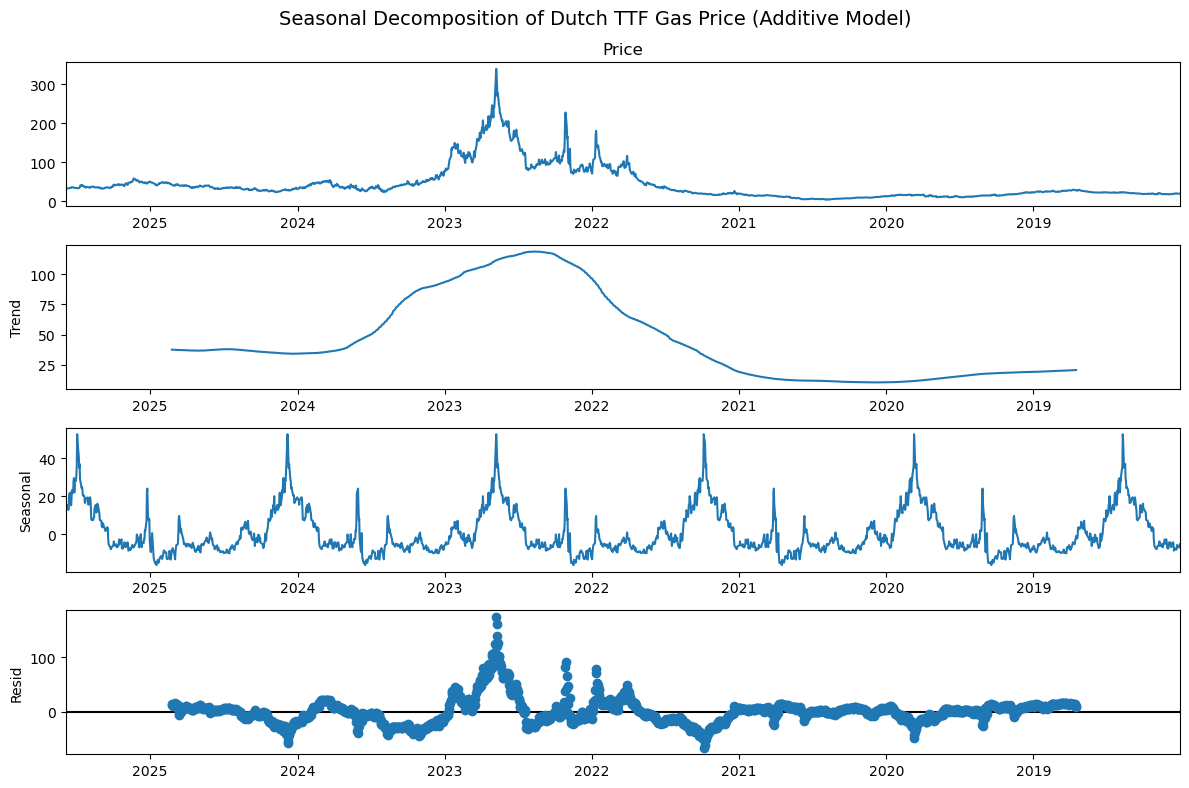

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Ensure datetime index and no missing values
df = df.copy()
df = df[['Price']].dropna()
df.index = pd.to_datetime(df.index)

# Perform additive decomposition
result = seasonal_decompose(df['Price'], model='additive', period=365)

# Plot components
fig = result.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Seasonal Decomposition of Dutch TTF Gas Price (Additive Model)', fontsize=14)
plt.tight_layout()
plt.savefig("../plots/seasonal_decomposition.jpg")
plt.show()
plt.close()

**Seasonality:** There's a clear annual seasonal pattern, with prices rising during winter months.

**Trend:** Long-term trends highlight structural shifts in pricing, such as supply shocks, geopolitical tensions, or policy changes.

**Residuals:** Sharp, irregular spikes (especially during 2021–2022) suggest exogenous shocks (e.g., the European energy crisis) that traditional models may struggle to capture.

Although the time series clearly exhibits both trend and seasonality, I perform an Augmented Dickey-Fuller (ADF) test to statistically confirm non-stationarity.

In [8]:
from statsmodels.tsa.stattools import adfuller

# Drop missing values (important before statistical tests)
series = df['Price'].dropna()

# Run ADF Test
adf_result = adfuller(series)

# Extract and print results
print("Augmented Dickey-Fuller Test Results")
print(f"ADF Statistic      : {adf_result[0]:.4f}")
print(f"p-value            : {adf_result[1]:.4f}")
print(f"Critical Values    :")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.4f}")

# Interpretation
if adf_result[1] > 0.05:
    print("\n🟡 The series is likely **non-stationary** (fail to reject H0). Consider differencing.")
else:
    print("\n🟢 The series is likely **stationary** (reject H0).")

with open("../outputs/adf_test_original_price_series.txt", "w") as f:
    f.write("Augmented Dickey-Fuller Test Results\n")
    f.write(f"ADF Statistic      : {adf_result[0]:.4f}\n")
    f.write(f"p-value            : {adf_result[1]:.4f}\n")
    f.write("Critical Values    :\n")
    for key, value in adf_result[4].items():
        f.write(f"  {key}: {value:.4f}\n")
    f.write("\n")
    if adf_result[1] > 0.05:
        f.write("🟡 The series is likely NON-STATIONARY (fail to reject H0). Consider differencing.\n")
    else:
        f.write("🟢 The series is likely STATIONARY (reject H0).\n")


Augmented Dickey-Fuller Test Results
ADF Statistic      : -2.1592
p-value            : 0.2214
Critical Values    :
  1%: -3.4338
  5%: -2.8630
  10%: -2.5676

🟡 The series is likely **non-stationary** (fail to reject H0). Consider differencing.


#### Interpretation of ADF test:

 - The ADF statistic (–2.16) is not more negative than any of the critical values (especially –2.86 at 5%).
 - p-value > 0.05, so we fail to reject the null hypothesis (H₀) of a unit root.

 **Conclusion:** The time series is non-stationary. This aligns with the visual trend seen above. 
 Non-stationary time-series means mean and variance change over tiem (due to trend and seasonality). This violates the assumptions of statistical models like ARIMA and regression. Most models require stationarity to produce reliable forecasts. 

 I will now apply first-order differencing to remove the trend component and re-test for stationarity. 

In [9]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Apply first-order differencing
df['Price_Diff'] = df['Price'].diff()
differenced_series = df['Price_Diff'].dropna()

# ADF Test after differencing
adf_result_diff = adfuller(differenced_series)

# Display results
print("📉 Augmented Dickey-Fuller Test on Differenced Series")
print(f"ADF Statistic      : {adf_result_diff[0]:.4f}")
print(f"p-value            : {adf_result_diff[1]:.4f}")
print("Critical Values    :")
for key, value in adf_result_diff[4].items():
    print(f"  {key}: {value:.4f}")

# Optional: Comment on the result
if adf_result_diff[1] < 0.05:
    print("\n✅ The differenced series is likely STATIONARY (reject H₀).")
else:
    print("\n🟡 The differenced series may still be NON-STATIONARY (fail to reject H₀).")

with open("../outputs/adf_test_differenced_series.txt", "w") as f:
    f.write("Augmented Dickey-Fuller Test Results on Differenced Series\n")
    f.write(f"ADF Statistic      : {adf_result_diff[0]:.4f}\n")
    f.write(f"p-value            : {adf_result_diff[1]:.4f}\n")
    f.write("Critical Values    :\n")
    for key, value in adf_result_diff[4].items():
        f.write(f"  {key}: {value:.4f}\n")
    f.write("\n")
    if adf_result_diff[1] > 0.05:
        f.write("🟡 The series is likely NON-STATIONARY (fail to reject H0). Consider differencing.\n")
    else:
        f.write("🟢 The series is likely STATIONARY (reject H0).\n")


📉 Augmented Dickey-Fuller Test on Differenced Series
ADF Statistic      : -8.8925
p-value            : 0.0000
Critical Values    :
  1%: -3.4338
  5%: -2.8630
  10%: -2.5676

✅ The differenced series is likely STATIONARY (reject H₀).


The differenced series is now stationary. 

Saved ACF/PACF values to acf_pacf_values.csv

Significant ACF Lags:
[(0, 1.0), (1, 0.11472952144849602), (2, -0.13524936906819385), (4, 0.14200666597991488), (5, -0.08701306379770427), (9, -0.08175922714643617), (12, -0.08418457712267317), (23, 0.045200200553487835), (25, 0.06280840882229363), (29, 0.0752918155735826), (32, -0.044491512735435834), (35, 0.059236495142330654), (37, -0.0529212987977843), (38, -0.06294671026583527), (40, 0.0483591956398358), (43, -0.05091724582482219), (47, -0.05058337157110987), (50, 0.07172793106645448), (54, 0.09272961803105016)]

Significant PACF Lags:
[(0, 1.0), (1, 0.11472952144849605), (2, -0.150391819084734), (4, 0.13180371824770973), (5, -0.13572264202893988), (6, 0.061130023052248676), (9, -0.04510222374324352), (12, -0.10500799945004075), (16, 0.060152389259753775), (19, 0.04521539391603371), (23, 0.04504551080026715), (24, -0.046844919836998074), (25, 0.09283704689201373), (26, -0.05011158369051459), (33, -0.048862213508490945), (34, 0.04979299

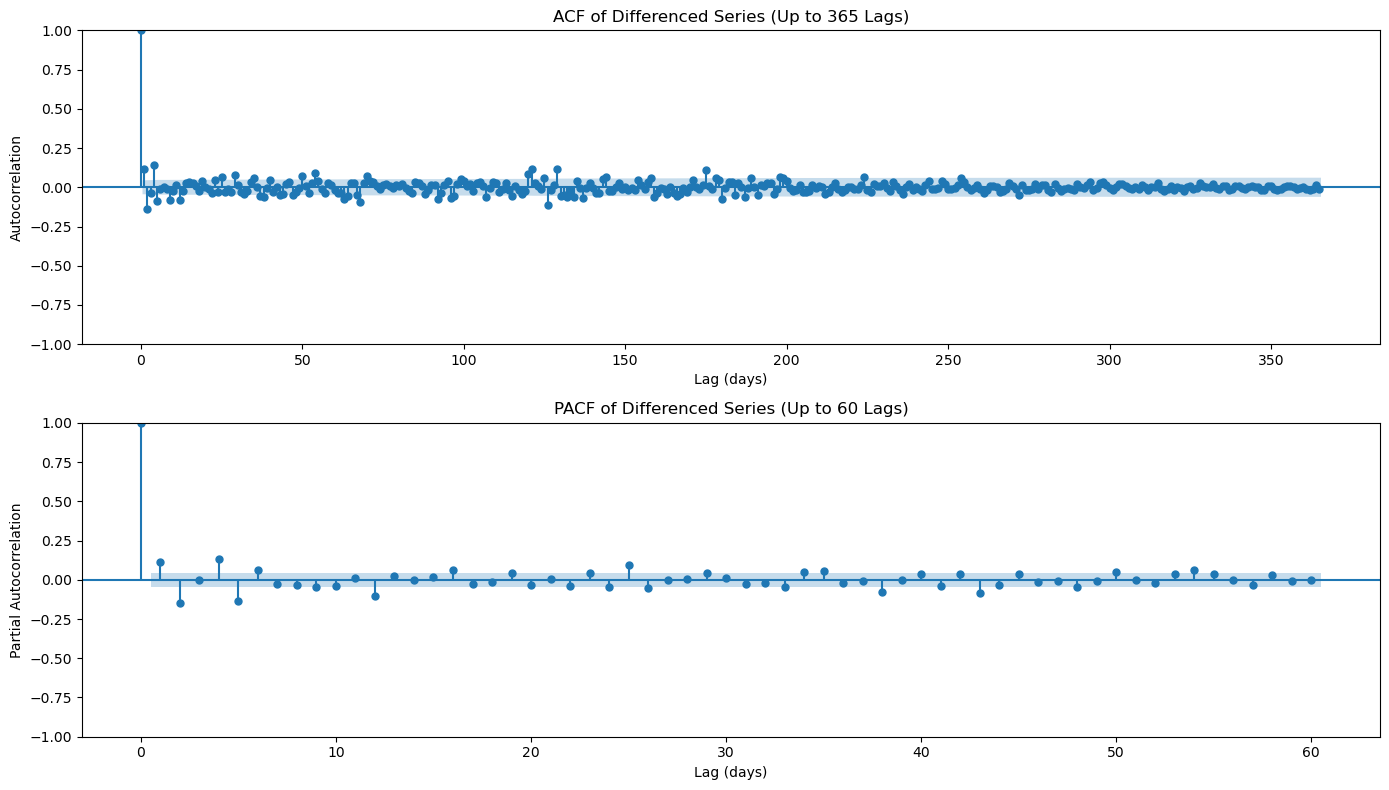

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Compute ACF and PACF for differenced series
lags = 60

acf_values = acf(differenced_series, nlags=lags)
pacf_values = pacf(differenced_series, nlags=lags, method='ywm')

# Create DataFrame and save
acf_pacf_df = pd.DataFrame({
    'Lag': range(len(acf_values)),
    'ACF': acf_values,
    'PACF': pacf_values
})

acf_pacf_df.to_csv("../outputs/acf_pacf_values.csv", index=False)
print("Saved ACF/PACF values to acf_pacf_values.csv")

# Confidence interval (approx. 1.96 / sqrt(N))
conf_interval = 1.96 / np.sqrt(len(differenced_series))
acf_sig_lags = [(i, val) for i, val in enumerate(acf_values) if abs(val) > conf_interval]
pacf_sig_lags = [(i, val) for i, val in enumerate(pacf_values) if abs(val) > conf_interval]

print("\nSignificant ACF Lags:")
print(acf_sig_lags)

print("\nSignificant PACF Lags:")
print(pacf_sig_lags)

with open("../outputs/significant_lags_acf_pacf_differenced_series.txt", "w") as f:
    f.write(" Significant ACF Lags:\n")
    for lag, val in acf_sig_lags:
        f.write(f"Lag {lag}: {val:.4f}\n")
    
    f.write("\n Significant PACF Lags:\n")
    for lag, val in pacf_sig_lags:
        f.write(f"Lag {lag}: {val:.4f}\n")

# Plot ACF and PACF
# Set maximum lags
max_lags = 365
fig, ax = plt.subplots(2, 1, figsize=(14, 8))

plot_acf(differenced_series, lags=max_lags, alpha=0.05, ax=ax[0])
ax[0].set_title("ACF of Differenced Series (Up to 365 Lags)")
ax[0].set_xlabel("Lag (days)")
ax[0].set_ylabel("Autocorrelation")

plot_pacf(differenced_series, lags=lags, alpha=0.05, method='ywm', ax=ax[1])
ax[1].set_title("PACF of Differenced Series (Up to 60 Lags)")
ax[1].set_xlabel("Lag (days)")
ax[1].set_ylabel("Partial Autocorrelation")
plt.tight_layout()
plt.savefig("../plots/acf_pacf.jpg")
plt.show()
plt.close()


### ACF & PACF 

Lag menas a past value. The price from yesterday is lag 1, the price from 2 days ago is lag 2 and so on. 

 - **ACF (Autocorrelation Function)** measures total correlation between a time series and its past values including both the **direct and the indirect effects.**
 - For example, ACF(5) measures the overall correlation between the value today (Y_t) and the value five days ago (Y_{t−5}). This includes the direct link (Y_t vs Y_{t-5}) and the indirect chain-reaction link (Y_{t−5}) influences (Y_{t−4}), which influences (Y_{t−3}) etc., which finally influences (Y_t).​

 - **PACF (Partial Autocorrelation Function)** measures the **direct effect** of a lag after removing the shorter intermediate lags. For example, PACF(5) measures the correlation between (Y_t) and (Y_{t-5}) that is not explained by lags 1, 2, 3, and 4. It isolates the unique contribution of lag 5.

A significant ACF or PACF value at a specific lag implies the past value **contains useful predictive information** about the current value.

#### Observed Patterns

 - **Significant ACF lags:** 1, 2, 4, 5, 9, 12, 25, 29, 50, 54  
 - **Significant PACF lags:** 1, 2, 4, 5, 6, 12, 25, 35, 38, 50  

These suggest that both **short-term (1–5 day)** and **medium-term (12, 25 day)** lags have predictive power (consistent with energy markets influenced by demand cycles and supply shocks).

### Model Order Selection
#### What PACF Represents (for AR order p)

 - PACF helps determine p in an Autoregressive AR(p) process.
 - In an AR(p) model, we assume today's price depends only on the last p days of prices.
 - So, to choose p, we look for the lag at which the PACF plot cuts off (i.e., where values drop inside the confidence band and stay there).
 - This makes sense in commodities like gas: a price shock may have a direct effect on the next few days but no influence after that.

 - Based on the observed results: Try p = 4, and later test p = 5 and 6.

#### Choosing MA Order (q) from ACF

 - ACF helps determine q in a Moving Average MA(q) process. 
 - In an MA(q) model, today's value depends on the random shocks (errors) from the last q periods.
 - So, to choose q, look for the lag at which the ACF plot cuts off (i.e., significant spikes stop abruptly).

 - Try: q = 4, and also test 5 and 6 based on observed ACF lags.

### Intuition
#### Scenario: Russian supply disruption → Natural gas price spike in Europe

Let’s say on Day 0, there's news that Russia is cutting gas supply to Europe. Prices immediately spike.
 - On Day 1, prices remain high because the news is fresh. This is expected.
 - On Day 2, prices are still high. Partly due to panic and partly because Day 1 was high.
 - Day 3 price is influenced by Day 2, which was influenced by Day 1, and so on.

**Is Day 3’s price influenced directly by Day 0, or only indirectly through Day 1 and Day 2?**
 - ACF will say yes, Day 3 and Day 0 are correlated, but that includes the indirect link (via Day 1 → Day 2).
 - PACF asks: *"If I already know Day 1 and Day 2, does Day 0 still add anything extra to predicting Day 3?"*
 - If PACF at lag 3 is still significant, it means Day 0 has a unique, direct influence on Day 3. If PACF at lag 3 is not significant, it means Day 3 is already explained well by Day 1 and 2 and Day 0 adds no new predictive power.


The lack of a clean "cutoff" in both ACF and PACF suggests that the series may not be pure AR or MA, but a mixed ARMA process. Additionally, lags like 12 hint at seasonality (possibly monthly effects).

### Candidate Models

 - **ARIMA(4,1,4)** is a strong starting point.
 - Test ARIMA(5,1,5), SARIMA models with seasonal terms.
 - Use **AIC/BIC** to choose the best fit. (will explore AIC/BIC in more detail in a bit).

### Beyond ARIMA:

ARIMA models are linear. They assume that the relationship between past and present values is a simple weighted sum. Real markets are full of non-linear dynamics, especially during volatile periods. A simple ARIMA(1,1,0) model cannot capture the complex behavior of an oil market reacting to a major geopolitical event. 

**That's where machine learning comes in.**

 - The lags identified by ACF/PACF are essential inputs (features) for more powerful models like Gradient Boosting (XGBoost) or Recurrent Neural Networks (LSTMs). 
 - These lags are used as features. feature_1 = price_t-1, feature_2 = price_t-2, feature_5 = price_t-5. ML model can then learn the complex, non-linear relationships between these features and the future price, something ARIMA cannot do.



c:\Users\yaswa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\yaswa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\yaswa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\yaswa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\yaswa\anaconda3\lib\site-

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1946
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -5785.444
Date:                Mon, 04 Aug 2025   AIC                          11588.889
Time:                        20:42:29   BIC                          11639.046
Sample:                             0   HQIC                         11607.331
                               - 1946                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.2316      0.028    -80.743      0.000      -2.286      -2.177
ar.L2         -2.6402      0.050    -52.948      0.000      -2.738      -2.543
ar.L3         -1.8003      0.040    -44.696      0.0

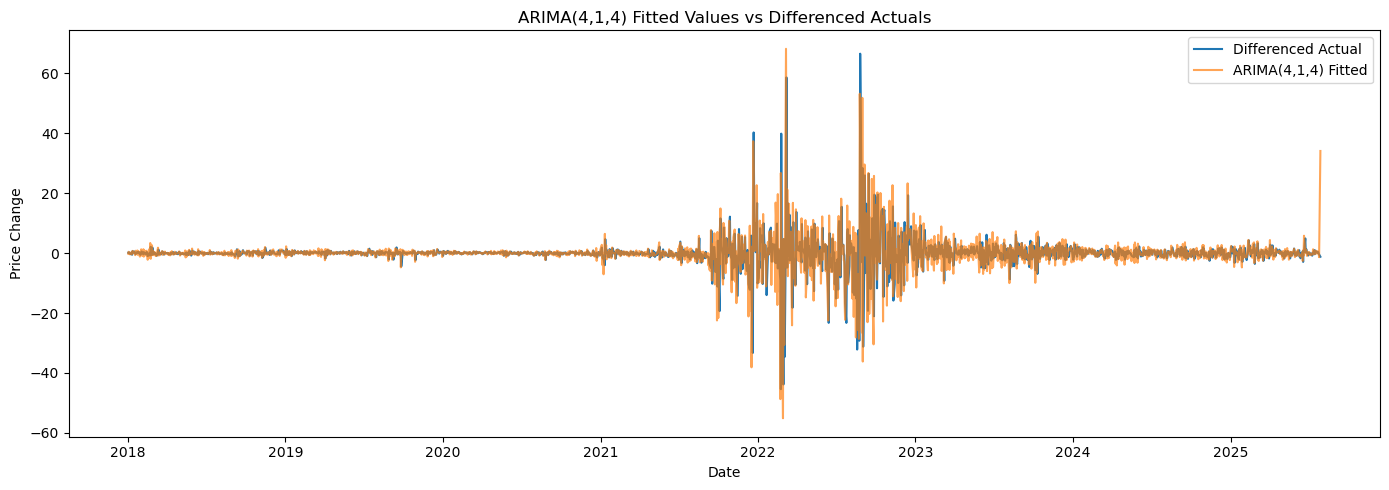

In [11]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Prepare data
price_col = 'Price'
ts = df[price_col].dropna()

# Fit ARIMA(4,1,4)
model = ARIMA(ts, order=(4, 1, 4))  # (p=4, d=1, q=4)
fitted_model = model.fit()

print(fitted_model.summary())

actual_diff = ts.diff().dropna()
fitted_diff = fitted_model.fittedvalues.diff().dropna()
common_index = actual_diff.index.intersection(fitted_diff.index)

# Plot fitted vs actual
plt.figure(figsize=(14, 5))
plt.plot(common_index, actual_diff.loc[common_index], label='Differenced Actual')
plt.plot(common_index, fitted_diff.loc[common_index], label='ARIMA(4,1,4) Fitted', alpha=0.7)
plt.title('ARIMA(4,1,4) Fitted Values vs Differenced Actuals')
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.legend()
plt.tight_layout()
plt.savefig("../plots/arima_fitted_vs_actual_differenced.jpg")
plt.show()
plt.close()


### Model Summary Interpretation

#### Coefficients:

 - All AR (AutoRegressive) and MA (Moving Average) terms are highly significant (p < 0.001).
 - AR and MA coefficients are large in magnitude (with alternating signs) indicating strong mean-reversion dynamics in the differenced series. This is expected in a price series that reverts after shocks. 

### Model Diagnostics:

 - sigma2 = 22.3860. This is the variance of residuals. Lower is better. Will be used later for error metrics like RMSE. 

 - Ljung-Box Q-Test (Lag 1): Prob(Q) = 0.47 → Fail to reject the null → No significant autocorrelation in residuals at lag 1. This indicates that the model has captured most fo the autocorrelative structure. This is a good sign. 

 - Very high Jarque-Bera (JB) value (110,275.61) and p < 0.01 → Residuals are not normally distributed. In the future models that can handle non - normality like LSTM will be helpful.

 - Heteroskedasticity (H) = 0.08. Significantly less than 1 → indicates presence of heteroskedasticity (non-constant variance in residuals). This is expected in commodity prices. GARCHG type models will be helpful in future extensions. 



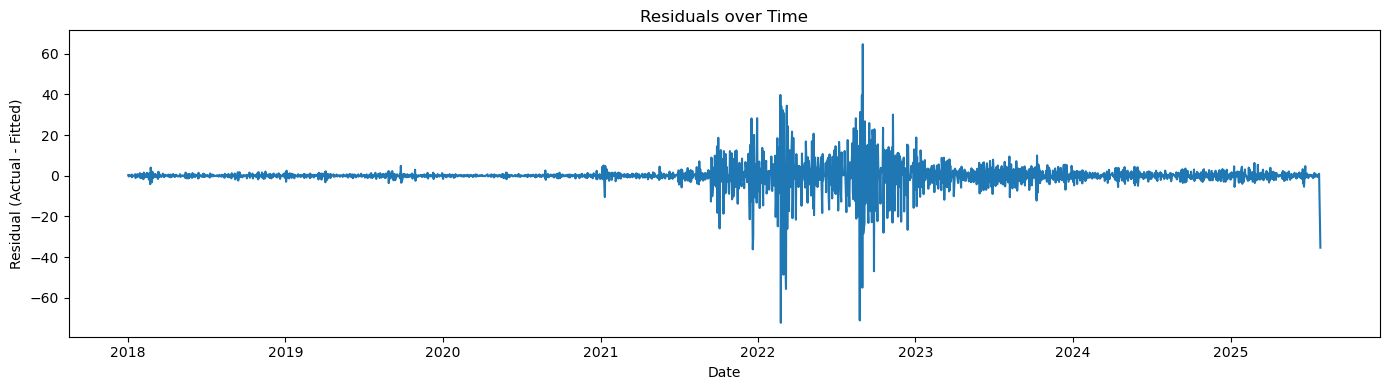

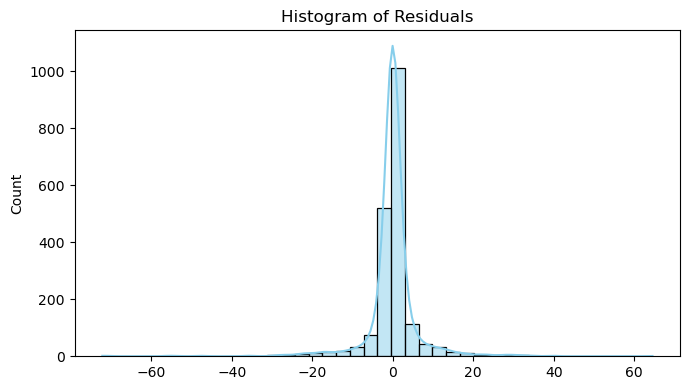

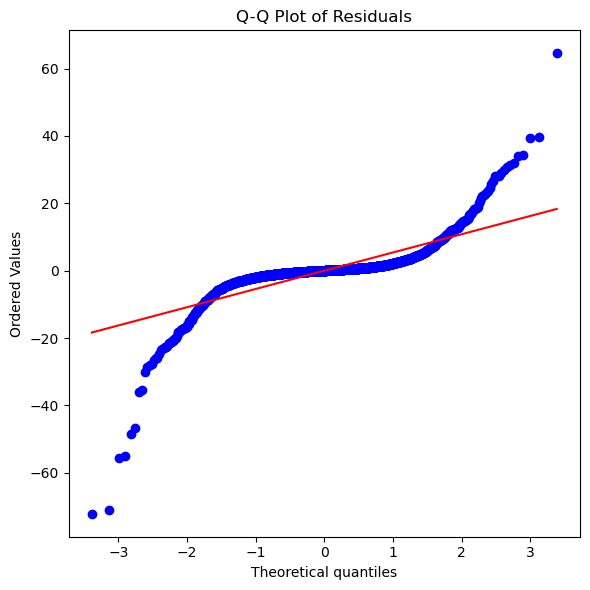

<Figure size 1000x400 with 0 Axes>

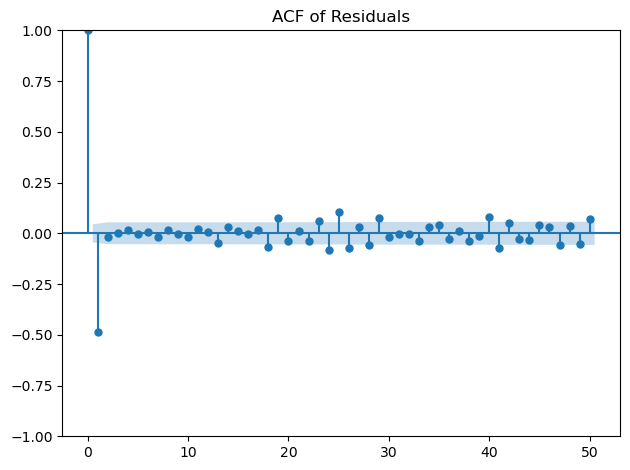

📊 Ljung-Box test results:
       lb_stat      lb_pvalue
10  466.274477   7.038860e-94
20  498.123744   7.189893e-93
30  574.219473  6.363824e-102


In [13]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Residuals
residuals = actual_diff.loc[common_index] - fitted_diff.loc[common_index]

# Plot residuals over time
plt.figure(figsize=(14, 4))
plt.plot(common_index, residuals)
plt.title('Residuals over Time')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Fitted)')
plt.tight_layout()
plt.savefig("../plots/residuals_time_series.jpg")
plt.show()
plt.close()

# Histogram + KDE
plt.figure(figsize=(7, 4))
sns.histplot(residuals, kde=True, bins=40, color='skyblue')
plt.title('Histogram of Residuals')
plt.tight_layout()
plt.savefig("../plots/residuals_histogram.jpg")
plt.show()
plt.close()

# Q-Q plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.savefig("../plots/residuals_Q_Q_plot.jpg")
plt.show()
plt.close()

# ACF of residuals
plt.figure(figsize=(10, 4))
plot_acf(residuals, lags=50)
plt.title('ACF of Residuals')
plt.tight_layout()
plt.savefig("../plots/residuals_acf.jpg")
plt.show()
plt.close()

# Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("📊 Ljung-Box test results:")
print(lb_test)

# Save Ljung-Box test results to a text file
with open("../outputs/ljung_box_test_results.txt", "w") as f:
    f.write("📊 Ljung-Box test results:\n")
    f.write(lb_test.to_string())  # nicely formatted DataFrame output

### Residual Diagnostics

#### Residuals Over Time Plot

**Expectation:** Residuals (Actual − Fitted) should fluctuate randomly around zero with no visible pattern or trend.  
**Result:** The mean seems centered around zero, which is good. However, heteroskedasticity (non-constant variance) is visible especially around 2022, where residual volatility spikes.  
**Implication:** Model underperforms during turbulent periods (likely the 2022 energy crisis), which makes sense for a linear model.

#### Histogram of Residuals with KDE

**Expectation:** Residuals should be normally distributed (bell-shaped).  
**Result:** The residuals are sharply peaked (leptokurtic) and slightly skewed with many extreme values (fat-tails).  
**Implication:** The error distribution isn't perfectly normal likely due to extreme price shocks. A model like GARCH might handle this better.

#### Q-Q Plot

**Expectation:** Points should lie on the red 45° line if residuals are normally distributed.  
**Result:** Heavy deviations in both tails. Clear S-shaped curve → non-normality.  
**Implication:** Confirms fat tails and non-normality in residuals. Again, a linear ARIMA can't fully capture volatility clustering.

#### ACF of Residuals

**Expectation:** All autocorrelations should lie within the confidence bands (i.e., look like white noise).  
**Result:** Most lags are inside the band, which is good. A few lags are very slightly outside, but nothing major.  
**Implication:** ARIMA(4,1,4) captures most autocorrelation. Minor residual autocorrelation may still be present.

#### Ljung-Box Test

**Expectation:** High p-values (e.g., > 0.05), suggesting residuals are uncorrelated.  
**Result:** Extremely low p-values (e.g., 7×10^-94) even at lag 10!  
**Implication:** Residuals still have autocorrelation ⇒ Model is not capturing all temporal structure.



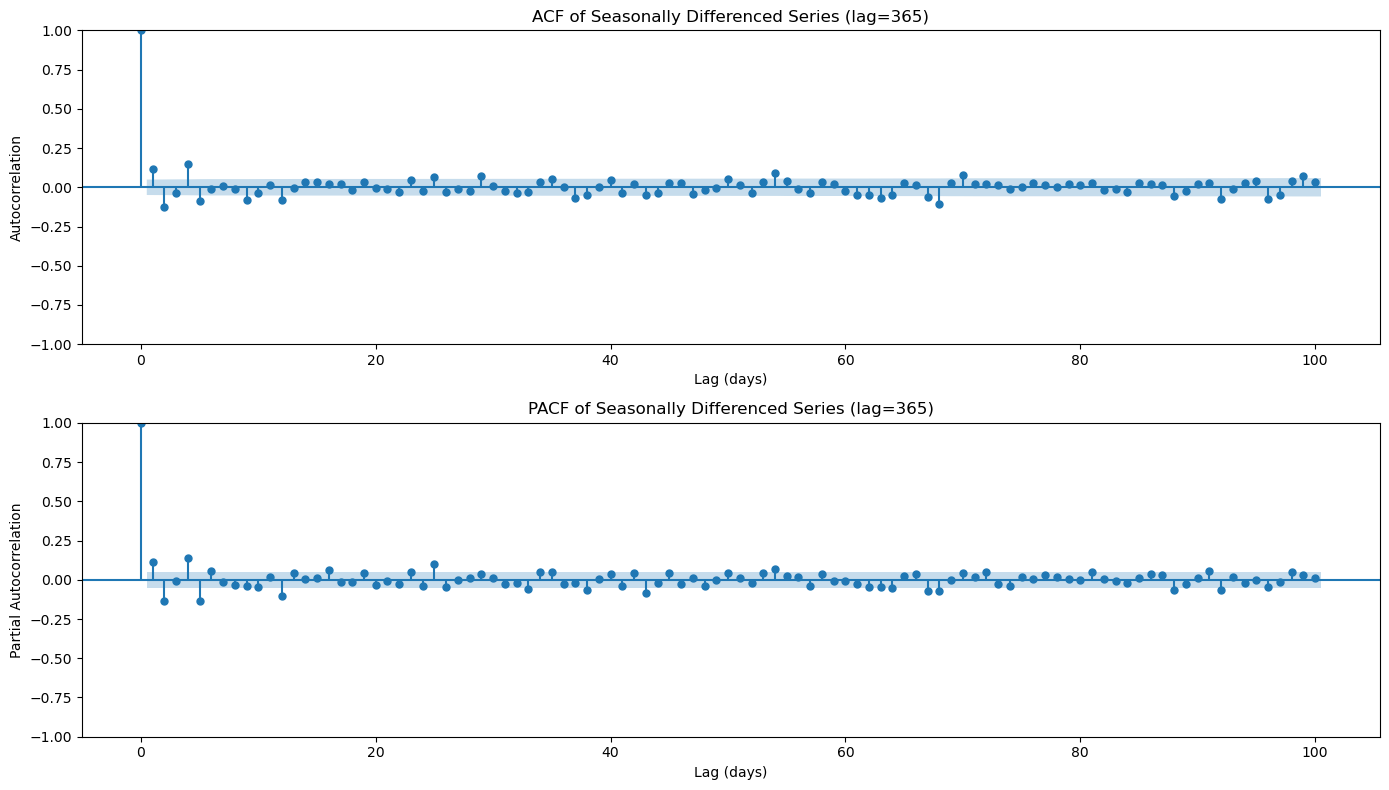

📌 Significant ACF Lags:
Lag 0: 1.0000
Lag 1: 0.1150
Lag 2: -0.1227
Lag 4: 0.1470
Lag 5: -0.0857
Lag 9: -0.0819
Lag 12: -0.0799
Lag 25: 0.0663
Lag 29: 0.0700
Lag 35: 0.0512
Lag 37: -0.0690
Lag 38: -0.0517
Lag 50: 0.0556
Lag 54: 0.0908
Lag 61: -0.0506
Lag 63: -0.0695
Lag 67: -0.0616
Lag 68: -0.1051
Lag 70: 0.0813
Lag 88: -0.0549
Lag 92: -0.0776
Lag 96: -0.0775
Lag 99: 0.0722
Lag 107: -0.0616
Lag 111: -0.0581
Lag 120: 0.0882
Lag 121: 0.0970
Lag 125: 0.0570
Lag 126: -0.1042
Lag 129: 0.1375
Lag 131: -0.0513
Lag 132: -0.0800
Lag 134: -0.0547
Lag 137: -0.0720
Lag 141: -0.0690
Lag 143: 0.0536
Lag 144: 0.0674
Lag 158: 0.0715
Lag 159: -0.0582
Lag 165: -0.0629
Lag 166: -0.0885
Lag 167: -0.0756
Lag 175: 0.1086
Lag 178: 0.0823
Lag 180: -0.0869
Lag 184: -0.0494
Lag 185: 0.0663
Lag 187: -0.0915
Lag 189: 0.0554
Lag 190: -0.0515
Lag 191: -0.0629
Lag 198: 0.0930
Lag 199: 0.0937
Lag 200: 0.0638
Lag 207: -0.0549
Lag 224: 0.0833
Lag 233: 0.0619
Lag 236: -0.1027
Lag 245: -0.0521
Lag 254: 0.0668
Lag 261: -0.

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
import numpy as np

seasonally_differenced = df['Price'].diff(1).diff(365).dropna()

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(14, 8))

plot_acf(seasonally_differenced, lags=100, alpha=0.05, ax=ax[0])
ax[0].set_title('ACF of Seasonally Differenced Series (lag=365)')
ax[0].set_xlabel('Lag (days)')
ax[0].set_ylabel('Autocorrelation')

plot_pacf(seasonally_differenced, lags=100, alpha=0.05, method='ywm', ax=ax[1])
ax[1].set_title('PACF of Seasonally Differenced Series (lag=365)')
ax[1].set_xlabel('Lag (days)')
ax[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.savefig("../plots/acf_pacf_seasonally_differenced.jpg")
plt.show()
plt.close()

# Compute significant lags
acf_values = acf(seasonally_differenced, nlags=400)
pacf_values = pacf(seasonally_differenced, nlags=400, method='ywm')
conf_interval = 1.96 / np.sqrt(len(seasonally_differenced))

acf_sig_lags = [(i, val) for i, val in enumerate(acf_values) if abs(val) > conf_interval]
pacf_sig_lags = [(i, val) for i, val in enumerate(pacf_values) if abs(val) > conf_interval]

# Print results
print("📌 Significant ACF Lags:")
for lag, val in acf_sig_lags:
    print(f"Lag {lag}: {val:.4f}")

print("\n📌 Significant PACF Lags:")
for lag, val in pacf_sig_lags:
    print(f"Lag {lag}: {val:.4f}")

with open("../outputs/significant_lags_acf_pacf_seasonally_differenced_series.txt", "w") as f:
    f.write(" Significant ACF Lags:\n")
    for lag, val in acf_sig_lags:
        f.write(f"Lag {lag}: {val:.4f}\n")
    
    f.write("\n Significant PACF Lags:\n")
    for lag, val in pacf_sig_lags:
        f.write(f"Lag {lag}: {val:.4f}\n")


### SARIMA - Choosing candidate model orders

The differencing orders are already set: d=1 (regular) and D=1 (seasonal) with a seasonal period of S=365. The task is to determine the AR and MA orders (p, q, P, Q) for a SARIMA(p, 1, q)(P, 1, Q)_365 model.

**Non-Seasonal Orders (p, q):** Since neither plot cuts off cleanly, I must test a few simple combinations. A good starting point is to choose low-order models that capture the initial significant lags. Candidate 1 (Simple): p=2, q=2. This captures the significant effects at lags 1 and 2. 

 - Candidate 1: p=2, q=2 -> This captures the significant effects at lags 1 and 2.
 - Candidate 2: p=5, q=5 -> This attempts to capture the effects up to lag 5.

**Seasonal Orders (P, Q):** A very large, significant spike is observed in ACF plot at Lag 365 with a value of -0.4982 followed by a sharp cut-off. This indicates a Moving Average (MA) process. Q=1
Because I identified the process as MA(1), I now expect its PACF to show the corresponding signature which is a tapering pattern. The PACF plot confirms that its pattern is consistent with an MA(1) process (i.e., it's tapering). The spike at lag 365 is that expected tapering pattern. Since the PACF is tapering and not cutting off, the seasonal AR order is P=0.

I will compare SARIMA(2, 1, 2)(0, 1, 1)_365. and SARIMA(5, 1, 5)(0, 1, 1)_365 using **AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion).** The model with the lowest AIC/BIC score is considered the best because it balances model fit with model complexity.



#### Current Bottlenecks & Limitations

SARIMA model fit is computationally expensive:
Even moderate-order seasonal models like SARIMA(2,1,2)(0,1,1,365) are taking over 8 hours to fit on local hardware (8 GB RAM, Intel i5).

Limited hardware capacity (both RAM and CPU) is a bottleneck for running full-scale SARIMA models over 7 years of daily data (~2500 data points) with annual seasonality.

SARIMA model tuning (AIC/BIC-based comparison) is currently paused until I can get a cloud subscription.

#### What's done

Full EDA and decomposition

ADF test confirms non-stationarity; differencing applied

ACF/PACF analysis (regular + seasonal)

ARIMA(4,1,4) trained and plotted successfully

Residuals analyzed with Ljung-Box test

Seasonal structure identified (strong spike at lag 365)

Candidate SARIMA models proposed for later evaluation

#### Next steps

Run SARIMA model on high-RAM cloud instance
(Google Colab Pro, Paperspace, or AWS)

Compare multiple SARIMA specs using AIC/BIC:

 - SARIMA(2,1,2)(0,1,1,365)
 - SARIMA(5,1,5)(0,1,1,365)

Perform residual diagnostics on the best model:

 - ACF/PACF of residuals
 - Normality, heteroskedasticity, autocorrelation

Extend to GARCH/LSTM models for volatility and non-linear behavior

Backtest prediction accuracy on test window (e.g., rolling window or expanding forecast)

Deploy a simple interface (Streamlit) to show model output

### Modeling Strategy Pivot

Due to memory limitations in fitting SARIMA with a large seasonal component (s=365), I will pivot to a more scalable and extensible ML method. 

**Implemented a Gradient Boosting Regressor (XGBoost / LightGBM) using lagged features, rolling averages, and calendar variables.**

Gradient boosting models support richer feature sets and scale better.

In [11]:
import pandas as pd

df = pd.read_csv("../dutch_ttf_prices/ICE_Dutch_TTF_Natural_Gas_Futures_Historical_Data.csv")
# Ensure datetime format
df['Date'] = pd.to_datetime(df['Date'])
# predict next day price
df['target'] = df['Price'].shift(-1)

# ===Top 25 Most Significant Lags (from ACF/PACF on seasonally differenced series) ===
# These are chosen based on absolute correlation strength and spread across short/long lags.
# This was a manual heuristic selection. 
top_25_lags = [
    1, 2, 4, 5, 25, 29, 35, 38, 54, 68,
    121, 126, 129, 143, 159, 165, 175, 178, 185, 198,
    199, 224, 236, 254, 365  # last one captures annual seasonality
]

# === Return-Based Lag Features ===
for lag in top_25_lags:
    df[f'diff_lag_{lag}'] = df['Price'].diff().shift(lag)

# === Seasonal Lag Features ===
# Price and return at lag 365 (explicitly included in top_25_lags too)
df['seasonal_price_lag'] = df['Price'].shift(365)
df['seasonal_return_lag'] = df['Price'].diff().shift(365)

# === Calendar Features ===
df['day_of_week'] = df['Date'].dt.dayofweek         # 0=Monday, 6=Sunday
df['month'] = df['Date'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)


# Rolling windows to use
windows = [3, 7, 14, 30]

# Rolling features on Price
for w in windows:
    df[f'roll_mean_{w}'] = df['Price'].shift(1).rolling(window=w).mean()
    df[f'roll_std_{w}'] = df['Price'].shift(1).rolling(window=w).std()
    df[f'roll_min_{w}'] = df['Price'].shift(1).rolling(window=w).min()
    df[f'roll_max_{w}'] = df['Price'].shift(1).rolling(window=w).max()

for w in windows:
    df[f'ema_{w}'] = df['Price'].shift(1).ewm(span=w, adjust=False).mean()
    df[f'price_vs_ema_{w}'] = df['Price'] / df[f'ema_{w}']

df_model = df.dropna().copy()
print(df.shape)
print(df['diff_lag_365'].isna().sum())
print(df['diff_lag_365'].notna().sum())
print(df_model.shape)





(1946, 62)
366
1580
(1578, 62)


Since lags were statistically selected (via ACF/PACF) not randomly added using 25 lag features is unlikely to lead to overfitting. Dropping rows with NA values brought down the number of rows to 1578 from 1946. This 19% decrease in the number of rows, though material, is accpetable for the current case as this still leaves me with 4.3 years (1578/365) of data. 

To limit total features to avoid overfitting and avoid resource constraints I will test the importance of all the features added above and use only the most importat features. This way I can prevent overfitting by removing noisy/duplicate lag windows. XGBoost’s internal feature importance is fast and reliable for this use case.

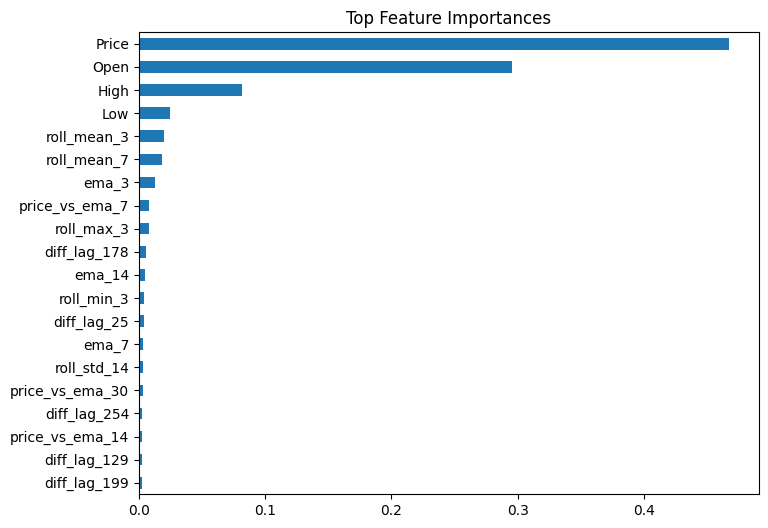

In [17]:
# Train a lightweight XGBoost model. 

from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd

model = XGBRegressor(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Select target
y = df_model['target']

# Select features
X = df_model.drop(columns=['target', 'Date', 'Vol.', 'Change %'])

split_index = int(0.8 * len(df_model))

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

# Save to text file
importances.to_string('../outputs/xgboost_feature_importances.txt')

#print(df_model[['target', 'roll_max_3', 'Price', 'Open', 'ema_3']].corr())


# Plot top 20
importances.head(20).plot(kind='barh', figsize=(8, 6))
plt.title("Top Feature Importances")
plt.gca().invert_yaxis()
plt.savefig("../plots/feature_comparison.jpg")
plt.show()
plt.close()

Dropping features with low importance. 

In [18]:
selected_features = importances[importances > 0.001].index.tolist()

X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

Retraining the model on the reduced feature set.  
Evaluating the model with RMSE< MAE, R-squared metrics on the test set. 

MAE:  0.4987
RMSE: 0.6444
R²:   0.9622


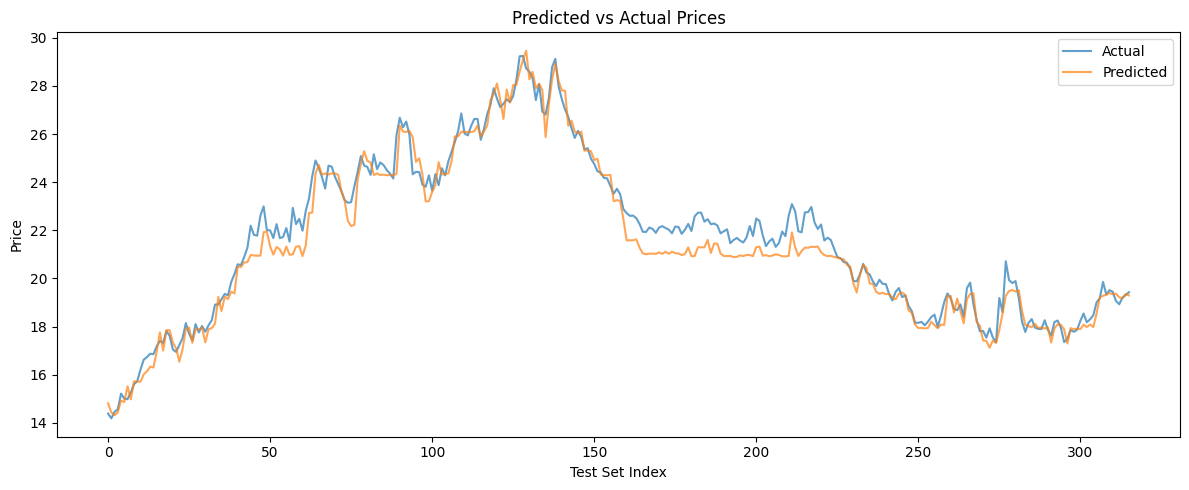

In [19]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

final_model = XGBRegressor(
    max_depth=4,
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    reg_alpha=0.5,
    random_state=42
)


final_model.fit(X_train_reduced, y_train)

# Predict on test set
y_pred = final_model.predict(X_test_reduced)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('Predicted vs Actual Prices')
plt.xlabel('Test Set Index')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.savefig("../plots/predicted_actual_xgboost.jpg")
plt.show()
plt.close()

Save final model + features metadata. 


In [20]:
import joblib

joblib.dump(final_model, '../models/final_xgb_model.pkl')
joblib.dump(selected_features, '../models/final_selected_features.pkl')

['../models/final_selected_features.pkl']